We have taken one of our best performing models and attached to it the custom layer that performs the segmentation.  Summarizing a lot the segmentation is done through an initial view of the color channels, it tries to find some pixels that are part of the background and some of the foregraund.
It expands on neighboring pixels to expand subsequent areas.
We took the version of the code in SegmentationNumpy and converted it to TensorFlow to fit as a network layer.

In [2]:
# !pip install neptune
# !pip install neptune-tensorflow-keras
# !pip install keras-cv

import neptune
from datetime import date
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras_cv as tfkv
from tensorflow import keras as tfk
from keras import applications
from tensorflow.keras.applications import MobileNetV2
from keras import layers as tfkl
from tensorflow.keras import mixed_precision
from io import StringIO
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

import keras_cv

import matplotlib.pyplot as plt
import numpy as np
import random

Segmentation with Tensorflow

In [ ]:
import tensorflow as tf
import random

def extract_features_tf(sample_dd, position_weight=10):
    img = sample_dd['img']
    fg = sample_dd['scribble_fg']
    bg = sample_dd['scribble_bg']

    # Get image size and flatten
    H, W, C = tf.shape(img)[0], tf.shape(img)[1], tf.shape(img)[2]
    img_flat = tf.reshape(img, [-1, C]) / 255.0  # Normalitation

    # Add pixel positions as additional features
    positions = tf.stack(tf.meshgrid(tf.range(H), tf.range(W), indexing='ij'), axis=-1)
    positions = tf.cast(tf.reshape(positions, [-1, 2]), tf.float32)
    positions = (positions / tf.stack([tf.cast(H, tf.float32), tf.cast(W, tf.float32)])) * position_weight  # Normalitation
    img_flat = tf.concat([img_flat, positions], axis=1)

    # Flat scribbles
    fg_flat = tf.reshape(fg, [-1])
    bg_flat = tf.reshape(bg, [-1])

    # Select foreground and background pixels
    foreground_pixels = tf.boolean_mask(img_flat, fg_flat == 1)
    background_pixels = tf.boolean_mask(img_flat, bg_flat == 1)

    # Balances the number of samples
    num_fg = tf.shape(foreground_pixels)[0]
    num_bg = tf.shape(background_pixels)[0]
    min_samples = tf.minimum(num_fg, num_bg)
    foreground_pixels = tf.random.shuffle(foreground_pixels)[:min_samples]
    background_pixels = tf.random.shuffle(background_pixels)[:min_samples]

    # Create labels
    labels_foreground = tf.ones([min_samples], dtype=tf.float32)
    labels_background = tf.zeros([min_samples], dtype=tf.float32)

    # Combines features and labels
    features = tf.concat([foreground_pixels, background_pixels], axis=0)
    labels = tf.concat([labels_foreground, labels_background], axis=0)

    return features, labels



def segment_image_KNN_tf(sample_dd, k=5, threshold=0.3, position_weight=10):
    
    img = sample_dd['img']
    H, W, C = tf.unstack(tf.shape(img))

    train_features, train_labels = extract_features_tf(sample_dd, position_weight=position_weight)

    # Normalitation of the train features
    train_features_mean = tf.reduce_mean(train_features, axis=0)
    train_features_std = tf.math.reduce_std(train_features, axis=0)
    train_features_scaled = (train_features - train_features_mean) / train_features_std

    # Prepare test characteristics
    test_features = tf.reshape(img, [-1, C]) / 255.0
    positions = tf.stack(tf.meshgrid(tf.range(H), tf.range(W), indexing='ij'), axis=-1)
    positions = tf.cast(tf.reshape(positions, [-1, 2]), tf.float32)

    # Correct normalization of positions
    positions = (positions / tf.stack([tf.cast(H, tf.float32), tf.cast(W, tf.float32)])) * position_weight
    test_features = tf.concat([test_features, positions], axis=1)
    test_features_scaled = (test_features - train_features_mean) / train_features_std

    # Calculate Euclidean distances
    distances = tf.sqrt(
        tf.reduce_sum(
            tf.square(
                tf.expand_dims(test_features_scaled, 1) - tf.expand_dims(train_features_scaled, 0)
            ),
            axis=2
        )
    )

    # Find the nearest 
    knn_indices = tf.argsort(distances, axis=1)[:, :k]
    knn_labels = tf.gather(train_labels, knn_indices)

    # Calculate average probability to be foreground
    probas = tf.reduce_mean(knn_labels, axis=1)

    # Applies threshold
    labels_test = tf.cast(probas >= threshold, tf.int32)

    # Resize to image size
    segmented_image_mask = tf.reshape(labels_test, [H, W])

    return segmented_image_mask



def extract_image_tf(img):
    
    treshold = 0.6
    size_sample_fg = 100
    size_sample_bg = 50

    # Normalitation
    img = tf.cast(img, tf.float32)
    img_norm = img / tf.reduce_max(img, axis=(0, 1), keepdims=True)

    # Cleans every channel
    mask = img_norm < treshold
    img_cleaned = img_norm * tf.cast(mask, tf.float32)

    # Mask for non-null pixels
    non_zero_mask = tf.reduce_any(img_cleaned > 0, axis=-1)

    # Random sampling by foreground
    fg = tf.cast(non_zero_mask, tf.uint8)
    non_zero_indices = tf.where(fg == 1)
    num_fg = tf.shape(non_zero_indices)[0]
    sampled_fg_indices = tf.random.shuffle(non_zero_indices)[:tf.minimum(size_sample_fg, num_fg)]
    selected_fg = tf.scatter_nd(
        sampled_fg_indices,
        tf.ones([tf.shape(sampled_fg_indices)[0]], dtype=tf.uint8),
        tf.cast(tf.shape(fg), tf.int64)  
    )

    # Random sampling by background
    bg = 1 - fg
    bg_non_zero_indices = tf.where(bg == 1)
    num_bg = tf.shape(bg_non_zero_indices)[0]
    sampled_bg_indices = tf.random.shuffle(bg_non_zero_indices)[:tf.minimum(size_sample_bg, num_bg)]
    selected_bg = tf.scatter_nd(
        sampled_bg_indices,
        tf.ones([tf.shape(sampled_bg_indices)[0]], dtype=tf.uint8),
        tf.cast(tf.shape(bg), tf.int64)  
    )
    
    image_test = {
        'img': img,
        'scribble_fg': selected_fg,
        'scribble_bg': selected_bg
    }

    # Generate the segmented mask
    segmented_image_mask = segment_image_KNN_tf(image_test, k=5, position_weight=100)

    # Apply the segmented mask to the original image
    segmented_pixels = tf.where(
        tf.expand_dims(segmented_image_mask, axis=-1) == 1,
        img,
        tf.zeros_like(img)
    )

    return segmented_pixels


def preprocess_image_for_extract_tf(image):
    
    # Resize to 96x96
    image_resized = tf.image.resize(image, [96, 96])

    # Ensure the image is in RGB format
    if image_resized.shape[-1] == 1:  # If grayscale, convert to RGB
        image_rgb = tf.image.grayscale_to_rgb(image_resized)
    else:
        image_rgb = image_resized

    # Normalize pixel values to [0, 1]
    image_normalized = tf.clip_by_value(image_rgb / 255.0, 0.0, 1.0)

    # Remove batch dimension if present
    if len(image_normalized.shape) == 4 and image_normalized.shape[0] == 1:
        image_normalized = tf.squeeze(image_normalized, axis=0)

    return image_normalized


In [ ]:
def custom_function(x):
   
    segmented_images = []

    for i in range(x.shape[0]):  # Iterate over the batch
        # Preprocess each image and apply segmentation
        preprocessed_image = preprocess_image_for_extract_tf(x[i])
        segmented_result = extract_image_tf(preprocessed_image)

        segmented_images.append(segmented_result)

    # Convert list of segmented images to a TensorFlow tensor
    segmented_images = tf.stack(segmented_images)

    # Resize segmented images to (96, 96)
    segmented_images = tf.image.resize(segmented_images, (96, 96))

    # Scale segmented images back to [0, 255] for consistency
    segmented_images = segmented_images * 255.0
    segmented_images = tf.cast(segmented_images, tf.float32)

    return segmented_images


Load Data and split on train,validation and test

In [6]:
# !cp /content/drive/MyDrive/training_set_cleaned_NODUPLICATE.npz .
# data = np.load('training_set_cleaned_NODUPLICATE.npz')
data = np.load('training_set_cleaned_NODUPLICATE.npz')

X = data['images']
y = data['labels']

# Assuming 'X' and 'y' are defined from the previous code
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Number of samples:", X.shape[0])
print("Number of features:", X.shape[1:])
print("Unique labels:", np.unique(y))

Shape of X: (11951, 96, 96, 3)
Shape of y: (11951, 1)
Number of samples: 11951
Number of features: (96, 96, 3)
Unique labels: [0 1 2 3 4 5 6 7]


In [7]:
# Converting to one-hot encoding
seed = 90
y = tfk.utils.to_categorical(y,len(np.unique(y)))

# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=0.1, stratify=np.argmax(y,axis=1))

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=len(X_test)*2, stratify=np.argmax(y_train_val,axis=1))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (8363, 96, 96, 3), y_train shape: (8363, 8)
X_val shape: (2392, 96, 96, 3), y_val shape: (2392, 8)
X_test shape: (1196, 96, 96, 3), y_test shape: (1196, 8)


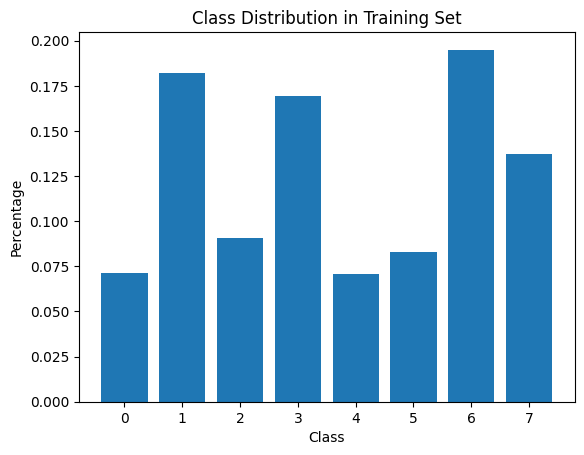

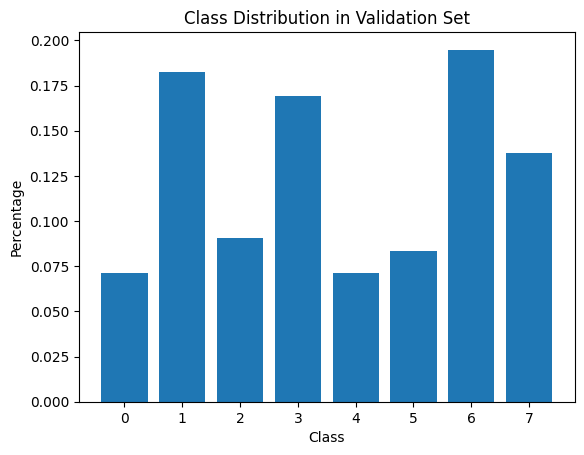

In [8]:

def plot_class_distribution(y, title):
  num_samples = np.zeros(8)
  tmp_y = np.argmax(y, axis=1)
  for i in range(8):
    num_samples[i] = np.sum(tmp_y == i)
  plt.bar(range(8), num_samples / np.sum(num_samples))
  plt.xlabel('Class')
  plt.ylabel('Percentage')
  plt.title(title)
  plt.show()

plot_class_distribution(y_train, 'Class Distribution in Training Set')
plot_class_distribution(y_val, 'Class Distribution in Validation Set')

Test segmentation on a single image

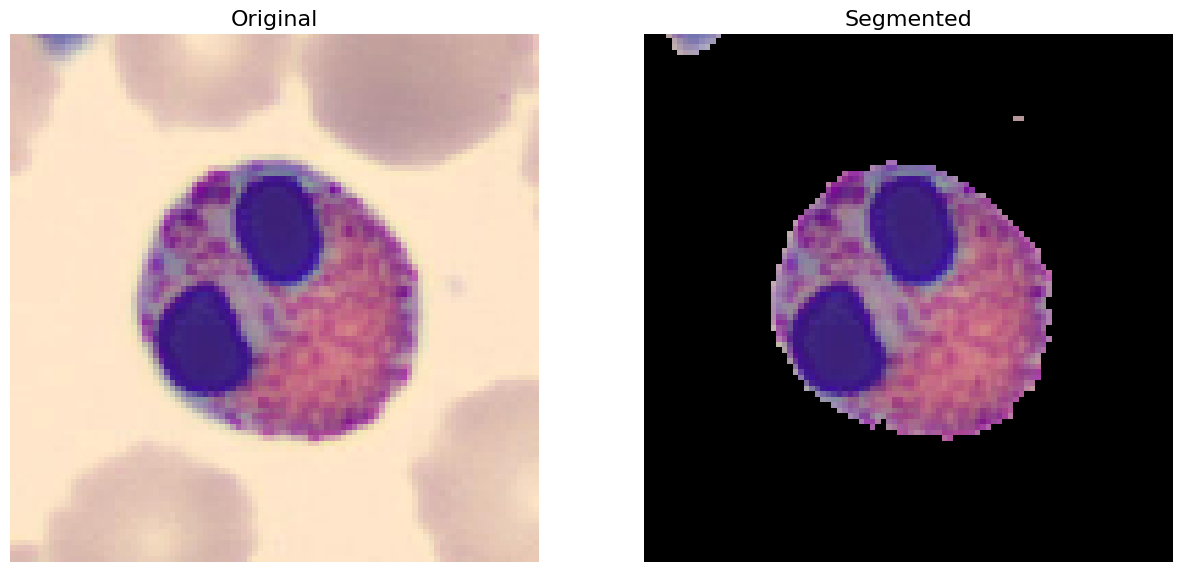

In [10]:

idx1, idx2 = 1201, 8  # Indici delle immagini da aumentare
image1 = X[idx1]

seg_img = extract_image_tf(preprocess_image_for_extract_tf(image1))

# Plot the original and segmented images side-by-side
plt.figure(figsize=(15, 8))

# Immagine originale
plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.title("Original", fontsize=16)
plt.axis('off')

# Segmented Image (Foreground only)
plt.subplot(1, 2, 2)
plt.imshow(seg_img)

plt.title("Segmented", fontsize=16)
plt.axis('off')

plt.show()

Configuration

In [13]:
data_params = {
    'batch_size': 32,
    'input_shape': (96, 96, 3),
    'num_classes': 8,
    'seed': 90
}

HYPERPARAMETERS = {
    "BATCH_SIZE": 32,
    "EPOCHS": 200,
    "LEARNING_RATE": 0.001,
    "LEARNING_DESCENT_PATIENCE": 5,
    "LEARNING_DESCENT_FACTOR": 0.5,
    "EARLY_STOPPING_PATIENCE": 10,
    "DROPOUT": 0.4,
    "LAYERS_FINE_TUNE": 400,
    "MODEL_NAME": "",
    "RAND_AUGMENT_MAGNITUDE": 0.4,
    "RAND_AUGMENT_AUGMENTATIONS_PER_IMAGE": 2
}

It follows the whole augmantation pipeline that is then inserted as an iterator in the train and on the validation set

In [14]:
from tensorflow.keras.layers import Lambda

AUTO = tf.data.AUTOTUNE


grid_mask = keras_cv.layers.GridMask(
      ratio_factor=(0, 0.5), rotation_factor=0.15, fill_mode="constant", fill_value=0.0)

cutout_constant = keras_cv.layers.RandomCutout(height_factor = 0.5, width_factor = 0.5, fill_mode="constant")

randomZoom = keras_cv.layers.RandomZoom(height_factor=0.5, width_factor=0.5)

hue = keras_cv.layers.RandomHue(factor=0.3, value_range=(0, 255))

channelShuffle = keras_cv.layers.ChannelShuffle(groups=3)

channelShift = keras_cv.layers.RandomChannelShift(value_range=(0, 255),factor=0.3)

simple_aug = tfk.Sequential(
    [
        tfkl.RandomFlip("horizontal"),
        tfkl.RandomRotation(factor=0.1, fill_mode = "nearest"),
        tfkl.RandomZoom(height_factor=0.1, width_factor=0.1, fill_mode = "nearest"),
    ]
)


rand_augment = tfkv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=HYPERPARAMETERS['RAND_AUGMENT_AUGMENTATIONS_PER_IMAGE'],
    magnitude=HYPERPARAMETERS['RAND_AUGMENT_MAGNITUDE'],
    geometric = True
)

grid_mask_or_rand_cutout = [
    cutout_constant,
    grid_mask
]

color_trasformations = [
     hue,
     channelShuffle,
     channelShift
]


def augment(images):
    image = tf.cast(images, tf.uint8)
    images = simple_aug(image)
    images = rand_augment(images)
    images = keras_cv.layers.RandomChoice(layers=grid_mask_or_rand_cutout)(images)
    images = keras_cv.layers.RandomChoice(layers=color_trasformations)(images)
    return images


In [10]:

train_data = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(HYPERPARAMETERS['EPOCHS'] * 100)
    .batch(HYPERPARAMETERS['BATCH_SIZE'])
    .map(
        lambda x, y: (augment(x), y),
        num_parallel_calls=AUTO,
    )
    .prefetch(AUTO)
)
'''.map(
    lambda x, y: tf.py_function(
        func=custom_function,
        inp=[x, y],
        Tout=(tf.float32, tf.float64)  # Update `Tout` with the appropriate output types
    ),
    num_parallel_calls=AUTO,
)'''

val_data = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .batch(HYPERPARAMETERS['BATCH_SIZE'])
    .map(
        lambda x, y: (augment(x), y),
        num_parallel_calls=AUTO,
    )
    .prefetch(AUTO)
)
'''.map(
    lambda x, y: tf.py_function(
        func=custom_function,
        inp=[x, y],
        Tout=(tf.float32, tf.float64)  # Update `Tout` with the appropriate output types
    ),
    num_parallel_calls=AUTO,
)'''


'.map(\n    lambda x, y: tf.py_function(\n        func=custom_function,\n        inp=[x, y],\n        Tout=(tf.float32, tf.float64)  # Update `Tout` with the appropriate output types\n    ),\n    num_parallel_calls=AUTO,\n)'

Plot the images only with augmentation

Image 1:
  Shape: (96, 96, 3)
  Type: <dtype: 'float32'>
Image 2:
  Shape: (96, 96, 3)
  Type: <dtype: 'float32'>
Image 3:
  Shape: (96, 96, 3)
  Type: <dtype: 'float32'>
Image 4:
  Shape: (96, 96, 3)
  Type: <dtype: 'float32'>
Image 5:
  Shape: (96, 96, 3)
  Type: <dtype: 'float32'>
Image 6:
  Shape: (96, 96, 3)
  Type: <dtype: 'float32'>
Image 7:
  Shape: (96, 96, 3)
  Type: <dtype: 'float32'>
Image 8:
  Shape: (96, 96, 3)
  Type: <dtype: 'float32'>
Image 9:
  Shape: (96, 96, 3)
  Type: <dtype: 'float32'>


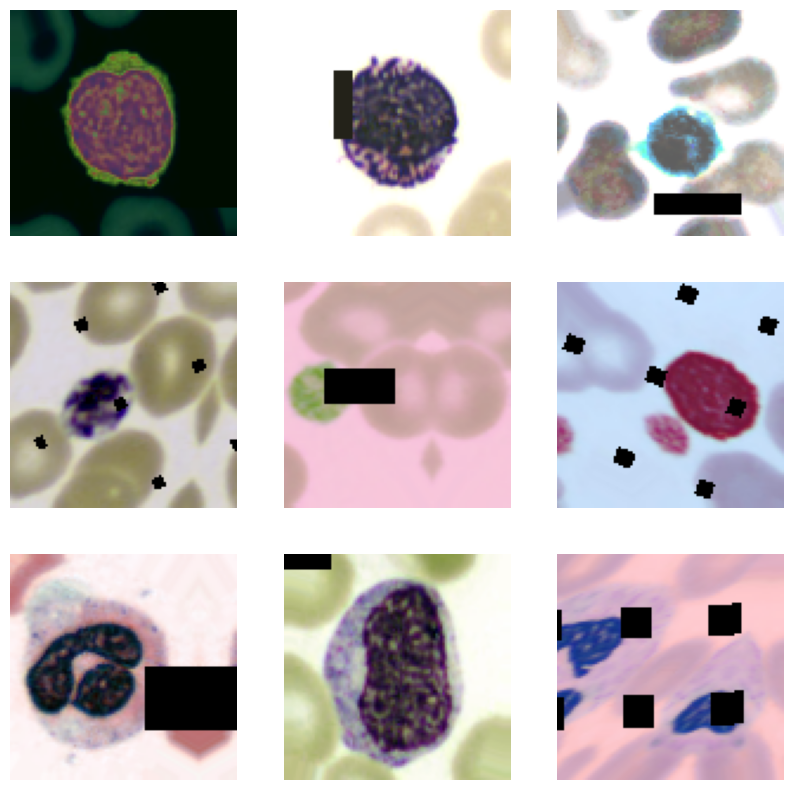

In [11]:
import matplotlib.pyplot as plt

sample_images, _ = next(iter(train_data))
plt.figure(figsize=(10, 10))

for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)

    # Debugging information
    print(f"Image {i+1}:")
    print(f"  Shape: {image.shape}")
    #print type
    print(f"  Type: {image.dtype}")

    # Plot the image
    plt.imshow(image.numpy().astype("uint8"))  # Ensure correct format for display
    plt.axis("off")
plt.show()



Configuration of the efficient net part with 400 trainable end layers

In [12]:
print('Loading model with ImageNet weights...')
MODEL_IMPORTED =tfk.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=data_params['input_shape'],
    pooling="avg",
    classes=8,
    classifier_activation="softmax",
    include_preprocessing=True,
    name="efficientnetv2-s",
)

# Set all layers in the convolutional base to Trainable (will FREEZE initial layers further below).
MODEL_IMPORTED.trainable = True

# Specify the number of layers to fine tune at the end of the convolutional base.
num_layers_fine_tune = HYPERPARAMETERS['LAYERS_FINE_TUNE']
num_layers = len(MODEL_IMPORTED.layers)

print("Num_layers fine tune " + str(num_layers_fine_tune))
print("Num_layers: " + str(num_layers))

# Freeze the initial layers in the convolutional base.
for model_layer in MODEL_IMPORTED.layers[:num_layers - num_layers_fine_tune]:
    model_layer.trainable = False

print(f"\nConfigured to fine tune the last", num_layers_fine_tune, "convolutional layers...\n")

Loading model with ImageNet weights...
Num_layers fine tune 400
Num_layers: 514

Configured to fine tune the last 400 convolutional layers...



tests that the iterator with augmentation would work on a model 

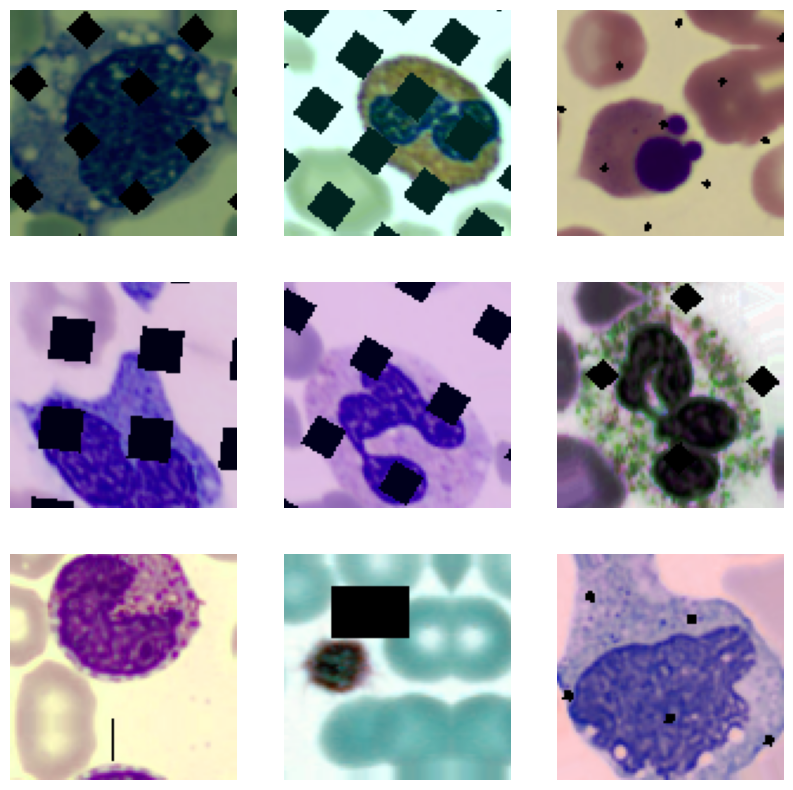

In [13]:
from tensorflow.keras.layers import Lambda, Input
from tensorflow.keras.models import Model

def build_model_finto():
  """Builds the Keras model.
  """
  inputs = Input(shape=data_params['input_shape'])
  # Create a Keras Model
  model = Model(inputs=inputs, outputs=inputs)
  return model

# Example usage:
sample_images, _ = next(iter(train_data))
model = build_model_finto() # Build the model first
processed_images = model(sample_images) # Then use the model to predict

# Display the processed images
plt.figure(figsize=(10, 10))
for i, image in enumerate(processed_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))  # Ensure you convert to uint8
    plt.axis("off")
plt.show()

tests that everything works with the insertion of the custom segmentation layer

In [14]:
class CustomSegmentationLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CustomSegmentationLayer, self).__init__(**kwargs)

    def call(self, inputs):
        """
        Process inputs batch-wise using TensorFlow operations.
        """
        def process_image(image):
            """
            Process a single image: preprocessing and segmentation.
            """
            # Preprocess the image (e.g., resizing)
            preprocessed_image = preprocess_image_for_extract_tf(image)
            # Apply segmentation logic (using TensorFlow-native functions)
            segmented_image = extract_image_tf(preprocessed_image)
            return segmented_image

        # Use tf.map_fn to apply process_image to each item in the batch
        outputs = tf.map_fn(process_image, inputs, dtype=tf.float32)
        return outputs



Instructions for updating:
Use fn_output_signature instead
<dtype: 'float32'>
<dtype: 'float32'>


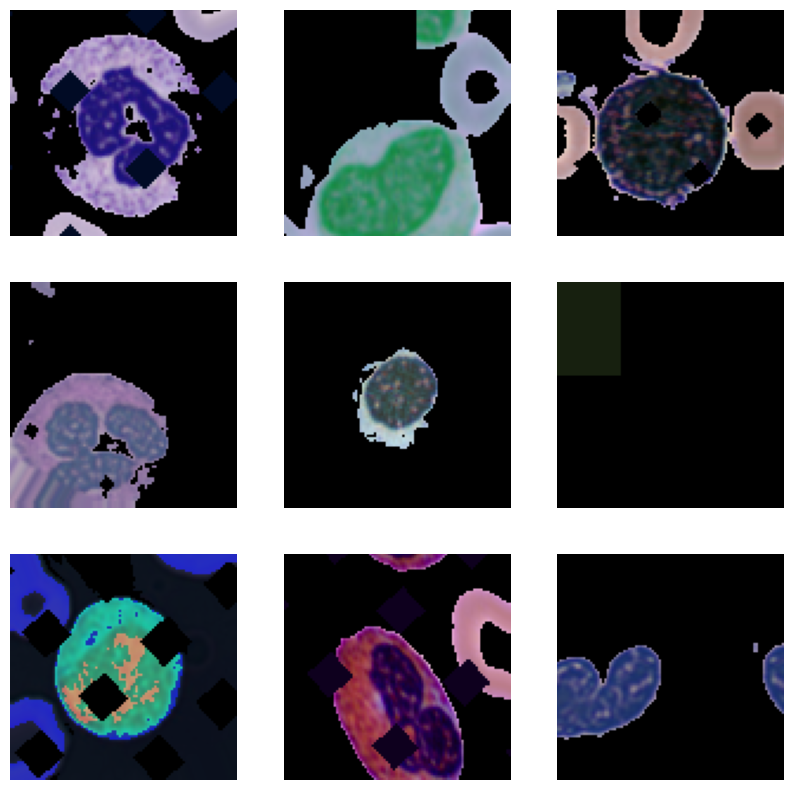

In [15]:
from tensorflow.keras.layers import Lambda, Input
from tensorflow.keras.models import Model

def build_model_finto():
  """Builds the Keras model.
  """
  inputs = Input(shape=data_params['input_shape'])

  x = CustomSegmentationLayer()(inputs)

  # Create a Keras Model
  model = Model(inputs=inputs, outputs=x)
  return model

# Example usage:
sample_images, _ = next(iter(train_data))
model = build_model_finto() # Build the model first
processed_images = model(sample_images) # Then use the model to predict
print(sample_images.dtype)
print(processed_images.dtype)
# Display the processed images
plt.figure(figsize=(10, 10))
for i, image in enumerate(processed_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)  # Ensure you convert to uint8
    plt.axis("off")
plt.show()

since everything works we can proceed with training the final model, we also configure neptune to save the results

In [16]:
from tensorflow.keras.layers import Lambda
def build_model():
  """Builds the Keras model.
  """
  inputs = tf.keras.Input(shape=data_params['input_shape'])
  x = CustomSegmentationLayer()(inputs)


  # Wrap the augmentation layer in a tf.function
  # Wrap augment_image in tf.py_function to execute eagerly

  x = MODEL_IMPORTED(x)

  x = tfkl.Dense(128, activation='relu')(x)
  x = tfkl.Dropout(HYPERPARAMETERS['DROPOUT'])(x)
  x = tfkl.Dense(64, activation='relu')(x)
  x = tfkl.Dropout(HYPERPARAMETERS['DROPOUT'])(x)


  outputs = tfkl.Dense(data_params['num_classes'], activation='softmax')(x)

  model = tfk.Model(inputs=inputs, outputs=outputs)
  print(model.summary())

  return model

In [ ]:

model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=HYPERPARAMETERS["LEARNING_RATE"]),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_segmentation_layer_1     │ (None, 96, 96, 3)      │             0 │
│ (CustomSegmentationLayer)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 1280)           │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,504,104 (78.22 MB)

 Trainable params: 18,970,352 (72.37 MB)

 Non-trainable params: 1,533,752 (5.85 MB)

None


In [ ]:
# !mkdir /content/drive/MyDrive/savage_model
# # prompt: class neptune callback

run = neptune.init_run(
    project=f"lp1807/Homework1" , # Replace with your Neptune project
    api_token="API_TOKEN",
    name="EfficientNetV2S-withFineTune_MoreDense_HEAVYAUG_60FT"
)

# Create a NeptuneCallback
class NeptuneCallback(tfk.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        run["model/train/accuracy"].log(logs["accuracy"])
        run["model/train/loss"].log(logs["loss"])
        run["model/val/accuracy"].log(logs["val_accuracy"])
        run["model/val/loss"].log(logs["val_loss"])


def saveNeptune_Drive():

  # Log the entire history dictionary to Neptune
  run["training/history"] = history.history  # <-- This line logs the entire training history

  for epoch in range(len(history.history['accuracy'])):
    run["training/epoch/train_accuracy"].log(history.history['accuracy'][epoch])
    run["training/epoch/val_accuracy"].log(history.history['val_accuracy'][epoch])
    run["training/epoch/train_loss"].log(history.history['loss'][epoch])
    run["training/epoch/val_loss"].log(history.history['val_loss'][epoch])

  model_summary = StringIO()
  model.summary(print_fn=lambda x: model_summary.write(x + "\n"))
  run["model/summary"] = model_summary.getvalue()

  # Log model weights and configuration
  run["model/weights"] = neptune.types.File.as_pickle(model.get_weights())
  run["model/config"] = model.get_config()

  model_file_path = f"SegmentationAugm.keras"
  model.save(model_file_path)

  # Log the .keras model file to Neptune
  run["model/file"].upload(model_file_path)

  # Convert history to DataFrame and save as CSV
  history_df = pd.DataFrame(history.history)
  history_file_path = f"SegmentationAugmhistory.csv"
  history_df.to_csv(history_file_path, index=False)

  # Log the CSV file to Neptune
  run["training/history_file"].upload(history_file_path)
  run["notebook"].upload("/content/drive/MyDrive/Colab Notebooks/the_boss.ipynb")

def saveHyperparameters():
    # Saving as Json
    run["hyperparameters"] = HYPERPARAMETERS


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/lp1807/Homework1/e/HOM-338


In [19]:
# !mkdir /content/drive/MyDrive/savage_model/checkpoints


# Define the checkpoint directory on Google Drive or locally
checkpoint_dir = '/content/drive/MyDrive/savage_model/checkpoints/'  # Modify this path as needed
os.makedirs(checkpoint_dir, exist_ok=True)
saveHyperparameters()

#neptune_cbk = NeptuneCallback()

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"SegmentationAugmBackup.keras",
    save_weights_only=False,  # Save only model weights, not the entire model
    monitor='val_loss',      # Monitor validation loss for checkpointing
    save_best_only=True,     # Save model at the end of each epoch regardless of improvement
    save_freq = "epoch",                 # Save checkpoint every 5 epochs
    verbose=1                 # Print message when saving a checkpoint
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=HYPERPARAMETERS["EARLY_STOPPING_PATIENCE"],  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# ReduceLROnPlateau callback to decrease the learning rate when the validation loss plateaus
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=HYPERPARAMETERS["LEARNING_DESCENT_FACTOR"],  # Reduce the learning rate by a factor of 0.5
    patience=HYPERPARAMETERS["LEARNING_DESCENT_PATIENCE"],  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,  # Lower bound on the learning rate
    verbose=1  # Print out a message when learning rate is reduced
)

# Train the model with the callbacks
history = model.fit(
    train_data,
    epochs=HYPERPARAMETERS["EPOCHS"],
    validation_data=val_data,
    callbacks=[ early_stopping, reduce_lr, checkpoint_callback]  # Include both the callbacks here
)

saveNeptune_Drive()

Epoch 1/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.2615 - loss: 1.9165
Epoch 1: val_loss improved from inf to 1.52802, saving model to SegmentationAugmBackup.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 305s 938ms/step - accuracy: 0.2617 - loss: 1.9161 - val_accuracy: 0.4243 - val_loss: 1.5280 - learning_rate: 0.0010
Epoch 2/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.4092 - loss: 1.5982
Epoch 2: val_loss improved from 1.52802 to 1.30661, saving model to SegmentationAugmBackup.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 244s 925ms/step - accuracy: 0.4092 - loss: 1.5981 - val_accuracy: 0.4925 - val_loss: 1.3066 - learning_rate: 0.0010
Epoch 3/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.4627 - loss: 1.4826
Epoch 3: val_loss improved from 1.30661 to 1.26967, saving model to SegmentationAugmBackup.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 246s 936ms/step - accuracy: 0.4627 - loss: 1.4826 - val_accuracy: 0.5380 - val_loss: 1.2697 - learning_rate: 0.0010
Epoch 4/200

[neptune] [error  ] Error occurred during asynchronous operation processing: Cannot upload file c:\content\drive\MyDrive\Colab Notebooks\the_boss.ipynb: Path not found or is a not a file.


Unfortunately given the discouragement of performance we per till forgot to plot the trend and use the model on the test set, fortunately we saved the training history and the model.

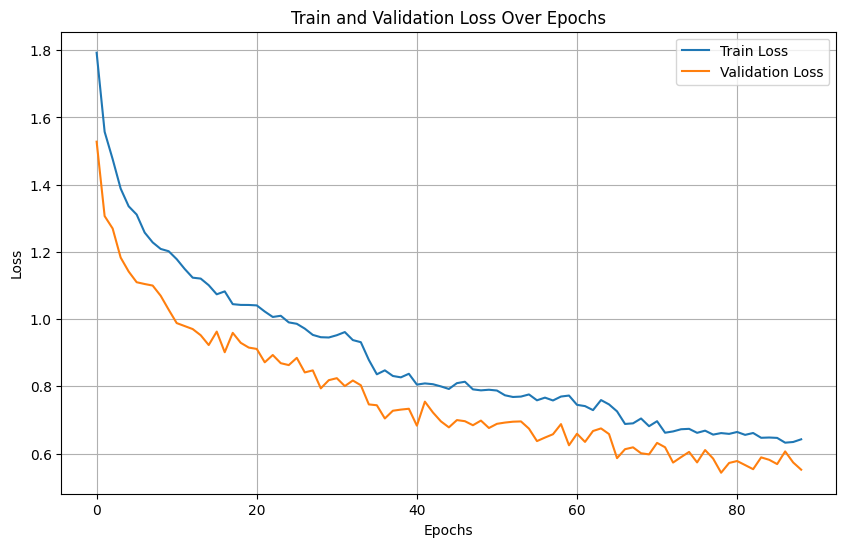

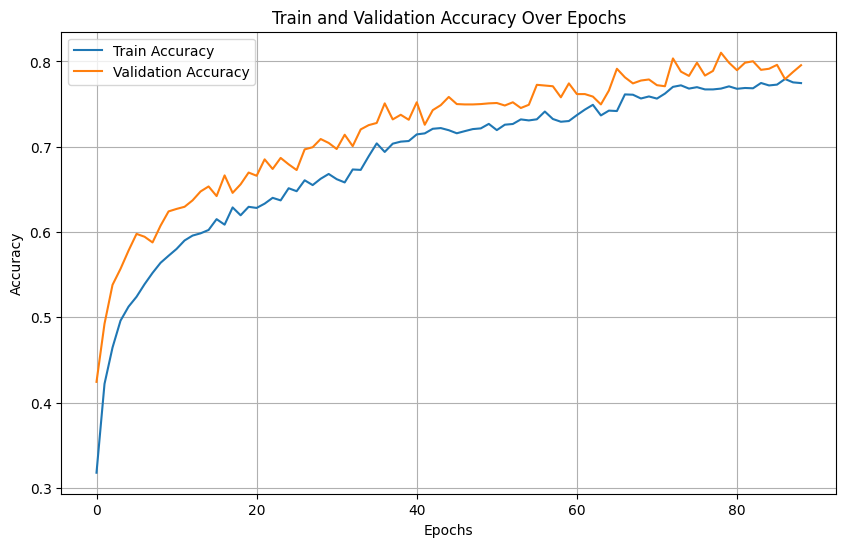

In [11]:

import pandas as pd
import matplotlib.pyplot as plt


data = pd.read_csv('SegmentationAugmhistory.csv')

# train loss e validation loss
plt.figure(figsize=(10, 6))
plt.plot(data['loss'], label='Train Loss')
plt.plot(data['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# train accuracy e validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(data['accuracy'], label='Train Accuracy')
plt.plot(data['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


We load the model by giving it the custom layer to be able to rebuild it, and evaluate the performance on the test set

Test Loss: 0.2674
Test Accuracy: 0.9097
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 460ms/step


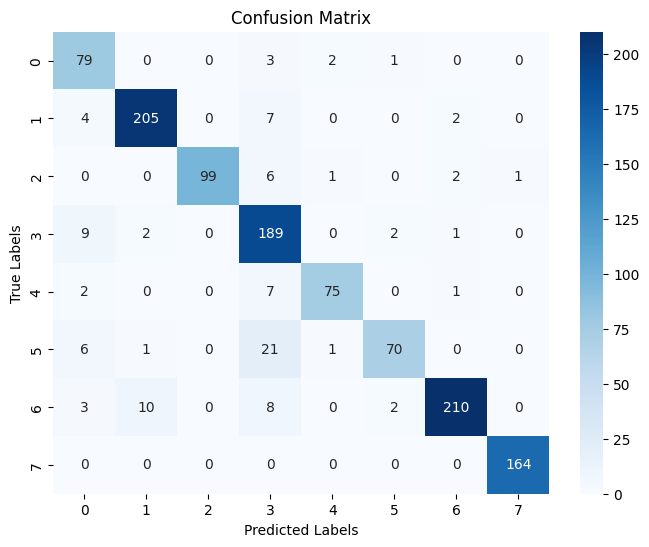

In [15]:

import tensorflow as tf
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable(package="Custom")
class CustomSegmentationLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CustomSegmentationLayer, self).__init__(**kwargs)

    def call(self, inputs):

        def process_image(image):
            """
            Process a single image: preprocessing and segmentation.
            """
            # Preprocess the image (e.g., resizing)
            preprocessed_image = preprocess_image_for_extract_tf(image)
            # Apply segmentation logic (using TensorFlow-native functions)
            segmented_image = extract_image_tf(preprocessed_image)
            return segmented_image

        # Use tf.map_fn to apply process_image to each item in the batch
        outputs = tf.map_fn(process_image, inputs, dtype=tf.float32)
        return outputs



model_path = 'SegmentationAugmBackup.keras'
model = tfk.models.load_model(model_path, custom_objects={
            "CustomSegmentationLayer": CustomSegmentationLayer
        })
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


# Generate the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In conclusion, we did not get good results using this custom segmentation layer, but certainly the idea allowed us to learn how to create and adapt codes that were not born to be placed within a neural network.
We can say (or rather we convince ourselves to say) that the days spent studying how to do it were not completely lost. The satisfaction when the custom layer finally started without errors and actually performed segmentation was really great :)